# **Reference:**

Chen, D., & Zhou, X. (2024). AttMoE: Attention with Mixture of Experts for remaining useful life prediction of lithium-ion batteries. Journal of Energy Storage, 84, 110780.

In [2]:
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

D:\Anaconda3\envs\torch_11\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\envs\torch_11\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Anaconda3\envs\torch_11\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# step 1. get device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# step 2. define functions for data processing and evaluation

In [4]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# step 3. load data from raw data

**requirement: pandas <= 0.24.2**

In [ ]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

# or step 3. load data from .npy file

**If the original data set cannot be read successfully, you can simply load the data I have extracted: CALCE.npy**

In [5]:
Battery = np.load('CALCE.npy', allow_pickle=True)
Battery = Battery.item()

# step 4. capacity figure

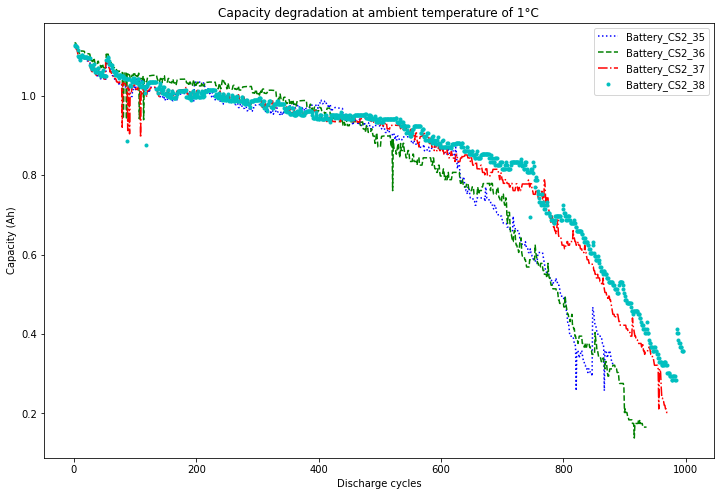

In [6]:
#Rated_Capacity = 1.1
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

# step 5. build net

In [7]:
from mixture_of_experts import MoE

class Attention(nn.Module):
    def __init__(self, feature_size, hidden_dim, nhead=4, dropout=0.0):
        super(Attention, self).__init__()
        self.query = nn.Linear(feature_size, hidden_dim)
        self.key = nn.Linear(feature_size, hidden_dim)
        self.value = nn.Linear(feature_size, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=nhead, dropout=dropout, batch_first=True)
        
    def forward(self, x):
        query, key, value = self.query(x), self.key(x), self.value(x)
        out, _ = self.attn(query, key, value)
        return out


class AttMoE(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=8, num_layers=1, nhead=4, dropout_att=0., dropout_rate=0.2, 
                 num_experts=8, device='cpu'):
        super(AttMoE, self).__init__()
        self.feature_size, self.hidden_dim = feature_size, hidden_dim
        self.dropout = nn.Dropout(dropout_rate)
        self.cell = Attention(feature_size=feature_size, hidden_dim=hidden_dim, nhead=nhead, dropout=dropout_att)
        self.linear = nn.Linear(hidden_dim, 1)
        
        experts = nn.Linear(hidden_dim, hidden_dim)
        # create moe layers based on the number of experts
        self.moe = MoE(dim=hidden_dim,
                       num_experts=num_experts,
                       experts=experts)
        self.moe = self.moe.to(device)
 
    def forward(self, x): 
        out = self.dropout(x)
        out = self.cell(x)   # cell 输出 shape (batch_size, seq_len=1, feature_size)
        out,_ = self.moe(out)
        out = out.reshape(-1, self.hidden_dim) # (batch_size, hidden_dim)
        out = self.linear(out)  # 经过线性层后，out的shape为(batch_size, 1)
        
        return out

# step 6. define train function

In [8]:
def train(lr=0.01, feature_size=64, hidden_dim=256, num_layers=1, nhead=4, weight_decay=0.0, EPOCH=500, 
          seed=0, dropout_att=0.0, metric='all', num_experts=16, device='cpu'):
    score_list, result_list = [], []
    for i in range(4):
        name = Battery_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        #print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = AttMoE(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                        nhead=nhead, dropout_att=dropout_att, num_experts=num_experts, device=device)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = [1],[1]
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X), torch.from_numpy(y)
            X, y = X.to(device), y.to(device)
            output = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy() #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x) #(batch_size,feature_size=1,input_size)
                    x = x.to(device)
                    pred = model(x) # 测试集 模型预测#pred shape为(batch_size=1, feature_size=1)
                    next_point = pred.cpu().data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                y_.append(point_list)#保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            if metric == 're':
                score = [re]
            elif metric == 'mae':
                score = [mae]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list

# step 7. use grid-search to find key parameters

In [9]:
Rated_Capacity = 1.1
feature_size = 64
EPOCH = 500
num_layers = 1
nhead = 4
weight_decay = 0.0
dropout_att = 0.0
metric = 'all'


for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
    for hidden_dim in [32, 64, 128, 256]:
        for num_experts in [4, 8, 16]:
            print('lr:{}, hidden_dim:{}, num_experts:{}'.format(lr, hidden_dim, num_experts))

            SCORE = []
            for seed in range(5):
                print('seed:{}'.format(seed))
                score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                                      nhead=nhead, weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout_att=dropout_att, 
                                      metric=metric, num_experts=num_experts, device=device)
                print('------------------------------------------------------------------')
                for s in score_list:
                    SCORE.append(s)

            if metric != 'all':
                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
            else:
                mlist = ['re', 'mae', 'rmse']
                for i in range(3):
                    s = [line[i] for line in SCORE]
                    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
            print('===================================================================')

lr:0.0001, hidden_dim:32, num_experts:4
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.5338
mae mean: 0.4263
rmse mean: 0.6417
lr:0.0001, hidden_dim:32, num_experts:8
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.6317
mae mean: 0.8354
rmse mean: 1.3134
lr:0.0001, hidden_dim:32, num_experts:16
seed:0
------------------------------

------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.1929
mae mean: 0.0935
rmse mean: 0.1176
lr:0.0005, hidden_dim:64, num_experts:8
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.1432
mae mean: 0.0949
rmse mean: 0.1181
lr:0.0005, hidden_dim:64, num_experts:16
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
---

------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.1073
mae mean: 0.0619
rmse mean: 0.0823
lr:0.001, hidden_dim:128, num_experts:16
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.1055
mae mean: 0.0631
rmse mean: 0.0830
lr:0.001, hidden_dim:256, num_experts:4
seed:0
------------------------------------------------------------------
seed:1
---

------------------------------------------------------------------
re mean: 0.1820
mae mean: 0.1384
rmse mean: 0.1614
lr:0.005, hidden_dim:256, num_experts:16
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.1186
mae mean: 0.0688
rmse mean: 0.0901
lr:0.01, hidden_dim:32, num_experts:4
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.1

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# step 8. set the obtained best parameters

In [10]:
lr = 5e-4
hidden_dim = 256
num_experts = 16
metric = 'all'

# same as default
Rated_Capacity = 1.1
feature_size = 64
EPOCH = 500
num_layers = 1
nhead = 4
weight_decay = 0.0
dropout_att = 0.0

SCORE = []
for seed in range(5):
    print('seed:{}'.format(seed))
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                          nhead=nhead, weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout_att=dropout_att, 
                          metric=metric, num_experts=num_experts, device=device)
    print('------------------------------------------------------------------')
    for s in score_list:
        SCORE.append(s)

if metric != 'all':
    print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
else:
    mlist = ['re', 'mae', 'rmse']
    for i in range(3):
        s = [line[i] for line in SCORE]
        print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
print('===================================================================')

seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.0698
mae mean: 0.0535
rmse mean: 0.0715
